<a href="https://colab.research.google.com/github/kashish-devgan/AI-ML/blob/main/Apple_Disease_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import zipfile
import os

# Define ZIP file path and extraction directory
ZIP_PATH = "/content/drive/MyDrive/APPLE.zip"  # Update if needed
EXTRACT_PATH = "/content/apple_dataset"

# Extract ZIP file
with zipfile.ZipFile(ZIP_PATH, 'r') as zip_ref:
    zip_ref.extractall(EXTRACT_PATH)

# Verify extracted files
print("Extracted files and directories:", os.listdir(EXTRACT_PATH))


Extracted files and directories: ['APPLE']


In [ ]:
# Correct base directory
BASE_DIR = os.path.join(EXTRACT_PATH, "APPLE")  # Adjust based on structure

# Define train, test, and valid directories
TRAIN_DIR = os.path.join(BASE_DIR, "TRAIN")
TEST_DIR = os.path.join(BASE_DIR, "TEST")
VALID_DIR = os.path.join(BASE_DIR, "VALID")

# Verify the corrected paths
print("Train Directory Exists:", os.path.exists(TRAIN_DIR))
print("Test Directory Exists:", os.path.exists(TEST_DIR))
print("Valid Directory Exists:", os.path.exists(VALID_DIR))


Train Directory Exists: True
Test Directory Exists: True
Valid Directory Exists: True


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define image size and batch size
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# Data augmentation for training set
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

valid_datagen = ImageDataGenerator(rescale=1./255)

train_data = train_datagen.flow_from_directory(TRAIN_DIR, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical')
valid_data = valid_datagen.flow_from_directory(VALID_DIR, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical')


# Validation and test data (only rescaling)
test_valid_datagen = ImageDataGenerator(rescale=1./255)

# Load test data
test_data = test_valid_datagen.flow_from_directory(
    TEST_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

# Get class labels
class_labels = list(train_data.class_indices.keys())
print("Class Labels:", class_labels)


Found 11846 images belonging to 8 classes.
Found 3548 images belonging to 8 classes.
Found 80 images belonging to 8 classes.
Class Labels: ['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blotch_Apple', 'Normal_Apple', 'Rot_Apple', 'Scab_Apple']


In [ ]:
import numpy as np
import os
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense, Flatten, Dropout, LSTM, TimeDistributed, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix
from google.colab import files
import shutil


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

valid_datagen = ImageDataGenerator(rescale=1./255)

# Load dataset
train_data = train_datagen.flow_from_directory(TRAIN_DIR, target_size=(224, 224), batch_size=32, class_mode='categorical')

valid_data = valid_datagen.flow_from_directory(VALID_DIR, target_size=(224, 224), batch_size=32, class_mode='categorical')

test_data = valid_datagen.flow_from_directory(TEST_DIR,target_size=(224, 224), batch_size=32, class_mode='categorical',shuffle=False)

class_labels = list(train_data.class_indices.keys())


Found 11846 images belonging to 8 classes.
Found 3548 images belonging to 8 classes.
Found 80 images belonging to 8 classes.


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Conv2D, BatchNormalization, Activation, MaxPooling2D,
    Flatten, Dense, Dropout, LSTM, TimeDistributed, GlobalAveragePooling2D
)

# Image dimensions
IMG_HEIGHT, IMG_WIDTH, CHANNELS = 224, 224, 3
TIME_STEPS = 7  # Example sequence length

# Input layer
input_layer = Input(shape=(TIME_STEPS, IMG_HEIGHT, IMG_WIDTH, CHANNELS))

# TimeDistributed CNN Block
cnn = TimeDistributed(Conv2D(32, (3, 3), padding="same", activation="relu"))(input_layer)
cnn = TimeDistributed(BatchNormalization())(cnn)
cnn = TimeDistributed(MaxPooling2D((2, 2)))(cnn)

cnn = TimeDistributed(Conv2D(64, (3, 3), padding="same", activation="relu"))(cnn)
cnn = TimeDistributed(BatchNormalization())(cnn)
cnn = TimeDistributed(MaxPooling2D((2, 2)))(cnn)

cnn = TimeDistributed(Conv2D(128, (3, 3), padding="same", activation="relu"))(cnn)
cnn = TimeDistributed(BatchNormalization())(cnn)
cnn = TimeDistributed(MaxPooling2D((2, 2)))(cnn)

# Flatten CNN output
cnn = TimeDistributed(GlobalAveragePooling2D())(cnn)  # Now correctly receives 4D input

# LSTM Block
lstm = LSTM(128, return_sequences=True)(cnn)
lstm = LSTM(64, return_sequences=False)(lstm)

# Fully connected layers
dense = Dense(128, activation="relu")(lstm)
dense = Dropout(0.5)(dense)

# ✅ Corrected Output Layer (Now connected)
output_layer = Dense(5, activation="softmax")(dense)  # Make sure it's connected

# Model definition
model = Model(inputs=input_layer, outputs=output_layer)

# Optimizer Fixes (AdamW for better generalization)
optimizer = tf.keras.optimizers.AdamW(learning_rate=0.0001, weight_decay=1e-5)

# Compile model
model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

# Model summary
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 7, 224, 224, 3) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 7, 224, 224,    │           896 │
│ (TimeDistributed)               │ 32)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 7, 224, 224,    │           128 │
│ (TimeDistributed)               │ 32)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ (None, 7, 112, 112,    │             0 │
│ (TimeDistributed)               │ 32)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_3              │ (None, 7, 112, 112,    │        18,496 │
│ (TimeDistributed)               │ 64)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_4              │ (None, 7, 112, 112,    │           256 │
│ (TimeDistributed)               │ 64)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_5              │ (None, 7, 56, 56, 64)  │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_6              │ (None, 7, 56, 56, 128) │        73,856 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_7              │ (None, 7, 56, 56, 128) │           512 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_8              │ (None, 7, 28, 28, 128) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_9              │ (None, 7, 128)         │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 7, 128)         │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 284,101 (1.08 MB)

 Trainable params: 283,653 (1.08 MB)

 Non-trainable params: 448 (1.75 KB)

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten

# Define a simple CNN feature extractor
cnn_model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Flatten()
])

# Compile model
cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Summary
cnn_model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 186624)         │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,392 (75.75 KB)

 Trainable params: 19,392 (75.75 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tensorflow.keras.layers import Dense, Dropout

# Add classification layers
cnn_model.add(Dense(128, activation='relu'))
cnn_model.add(Dropout(0.3))
cnn_model.add(Dense(len(class_labels), activation='softmax'))  # Output layer

# Compile the model
cnn_model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

# Train the model
history = cnn_model.fit(
    train_data,
    validation_data=valid_data,
    epochs=25,  # Faster training
    batch_size=32
)

# Evaluate the model
test_loss, test_acc = cnn_model.evaluate(test_data)
print(f"Test Accuracy: {test_acc * 100:.2f}%")

# Save the trained model
cnn_model.save("/content/drive/MyDrive/apple_leaf_cnn.keras")


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
371/371 ━━━━━━━━━━━━━━━━━━━━ 167s 430ms/step - accuracy: 0.5635 - loss: 1.5487 - val_accuracy: 0.4941 - val_loss: 1.8723
Epoch 2/25
371/371 ━━━━━━━━━━━━━━━━━━━━ 158s 425ms/step - accuracy: 0.7548 - loss: 0.6488 - val_accuracy: 0.5550 - val_loss: 1.2030
Epoch 3/25
371/371 ━━━━━━━━━━━━━━━━━━━━ 152s 410ms/step - accuracy: 0.7829 - loss: 0.6022 - val_accuracy: 0.5939 - val_loss: 1.3138
Epoch 4/25
371/371 ━━━━━━━━━━━━━━━━━━━━ 153s 413ms/step - accuracy: 0.8135 - loss: 0.5064 - val_accuracy: 0.6046 - val_loss: 1.2265
Epoch 5/25
371/371 ━━━━━━━━━━━━━━━━━━━━ 157s 425ms/step - accuracy: 0.8265 - loss: 0.4665 - val_accuracy: 0.6406 - val_loss: 1.1598
Epoch 6/25
371/371 ━━━━━━━━━━━━━━━━━━━━ 154s 414ms/step - accuracy: 0.8603 - loss: 0.3883 - val_accuracy: 0.6824 - val_loss: 1.4102
Epoch 7/25
371/371 ━━━━━━━━━━━━━━━━━━━━ 154s 416ms/step - accuracy: 0.8537 - loss: 0.3918 - val_accuracy: 0.6508 - val_loss: 1.3843
Epoch 8/25
371/371 ━━━━━━━━━━━━━━━━━━━━ 154s 416ms/step - accuracy: 0.8750 -

In [ ]:
# Print final training accuracy & loss
train_acc = history.history['accuracy'][-1]
val_acc = history.history['val_accuracy'][-1]
train_loss = history.history['loss'][-1]
val_loss = history.history['val_loss'][-1]

print(f"Final Training Accuracy: {train_acc:.4f}")
print(f"Final Validation Accuracy: {val_acc:.4f}")
print(f"Final Training Loss: {train_loss:.4f}")
print(f"Final Validation Loss: {val_loss:.4f}")


Final Training Accuracy: 0.9229
Final Validation Accuracy: 0.7246
Final Training Loss: 0.2180
Final Validation Loss: 2.0947


In [ ]:
from sklearn.metrics import classification_report

# Get true labels
y_true = test_data.classes  # True labels from test dataset

# Predict on test data
y_pred = cnn_model.predict(test_data)
y_pred_classes = y_pred.argmax(axis=1)  # Convert predictions to class indices

# Get class labels
class_labels = list(test_data.class_indices.keys())

# Generate classification report
report = classification_report(y_true, y_pred_classes, target_names=class_labels)

# Print the report
print(report)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step
                          precision    recall  f1-score   support

      Apple___Apple_scab       0.82      0.90      0.86        10
       Apple___Black_rot       0.91      1.00      0.95        10
Apple___Cedar_apple_rust       0.91      1.00      0.95        10
         Apple___healthy       1.00      0.70      0.82        10
            Blotch_Apple       0.91      1.00      0.95        10
            Normal_Apple       1.00      0.90      0.95        10
               Rot_Apple       0.91      1.00      0.95        10
              Scab_Apple       1.00      0.90      0.95        10

                accuracy                           0.93        80
               macro avg       0.93      0.92      0.92        80
            weighted avg       0.93      0.93      0.92        80



3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


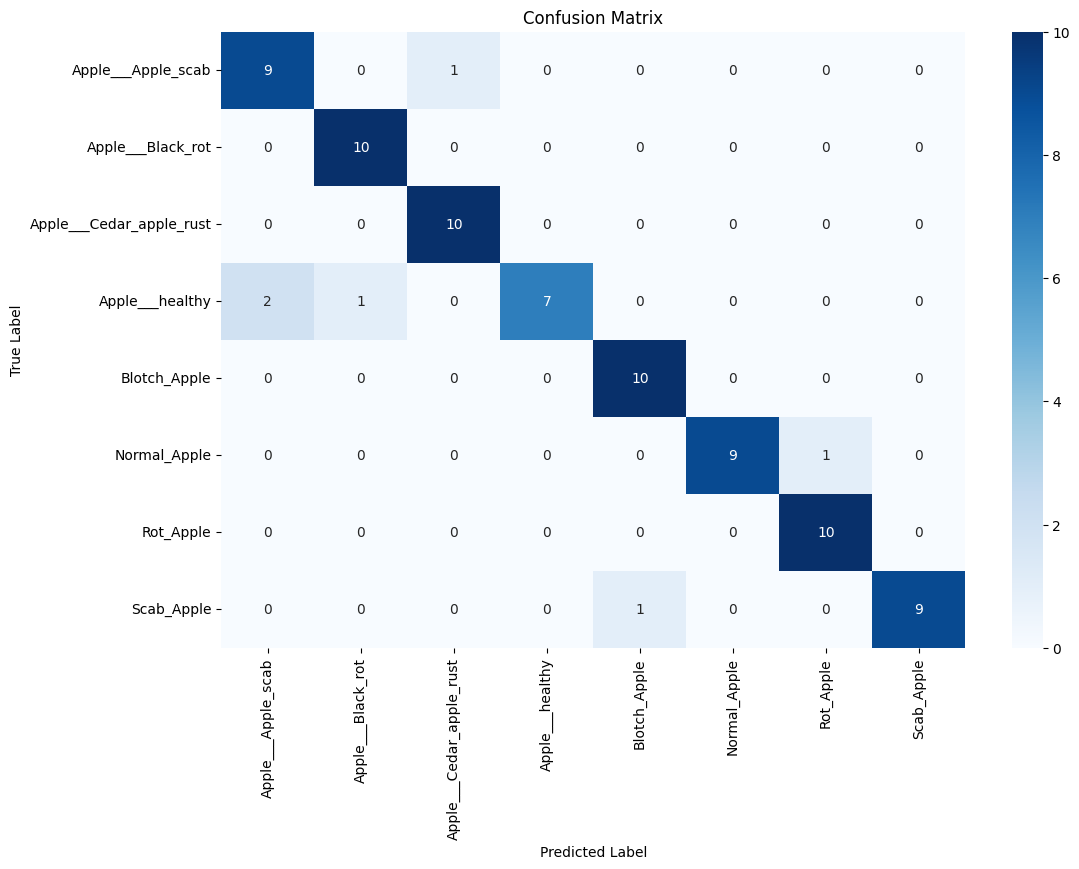

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Get true labels
y_true = test_data.classes

# Predict on test data
y_pred = cnn_model.predict(test_data)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert predictions to class indices

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Get class labels
class_labels = list(test_data.class_indices.keys())

# Plot confusion matrix
plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()



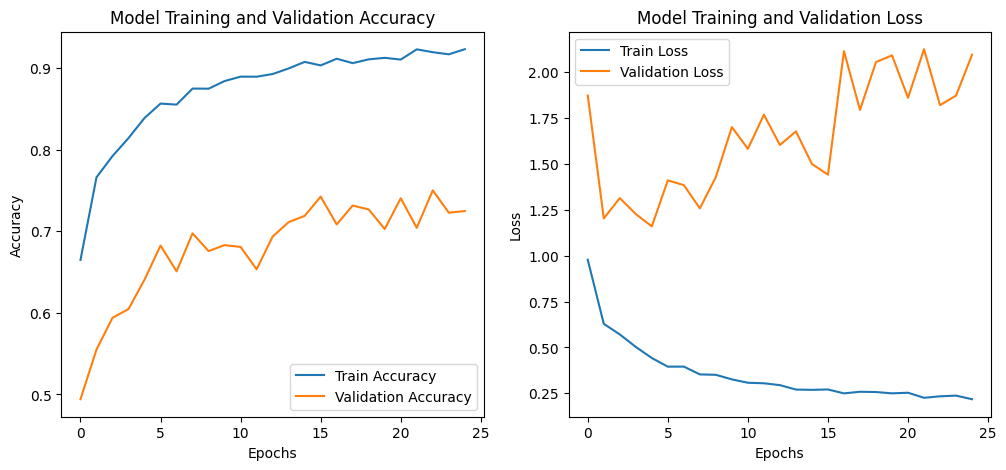

In [ ]:
import matplotlib.pyplot as plt

# Plot accuracy graph
plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Training and Validation Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Training and Validation Loss')
plt.legend()

plt.show()


In [ ]:
#Recording History in json
import json
with open("training_hist (1).json","w") as f:
    json.dump(history.history,f)

In [ ]:
import numpy as np
from tensorflow.keras.preprocessing import image
from google.colab import files
import shutil

# Function to predict disease
def predict_disease(img_path, model):
    img = image.load_img(img_path, target_size=(224, 224))  # Resize
    img_array = image.img_to_array(img) / 255.0  # Normalize
    img_array = np.expand_dims(img_array, axis=0)  # Reshape for model

    prediction = model.predict(img_array)  # Get predictions
    class_index = np.argmax(prediction)  # Get highest probability class
    class_name = class_labels[class_index]  # Get class name

    print(f"Predicted Disease: {class_name}")

# Upload image
uploaded = files.upload()

# Move uploaded file to a known path
image_path = list(uploaded.keys())[0]
shutil.move(image_path, "/content/user_image.jpg")

print("Image uploaded successfully!")

Saving 0fbdccdc-fb96-475a-92bb-65734592c895___FREC_C.Rust 3619_newGRR.JPG to 0fbdccdc-fb96-475a-92bb-65734592c895___FREC_C.Rust 3619_newGRR.JPG
Image uploaded successfully!


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


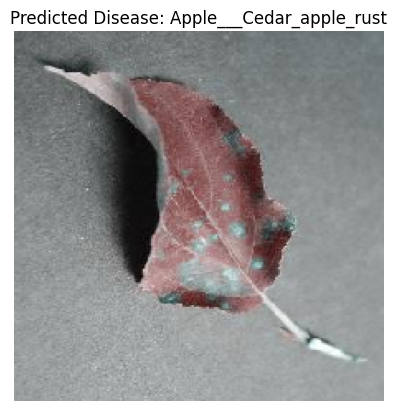

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

# Function to predict disease from uploaded image
def predict_disease(model):
    img_path = "/content/user_image.jpg"  # Uploaded image path
    img = image.load_img(img_path, target_size=(224, 224))  # Resize
    img_array = image.img_to_array(img) / 255.0  # Normalize
    img_array = np.expand_dims(img_array, axis=0)  # Reshape for model

    # Model prediction
    prediction = model.predict(img_array)
    class_index = np.argmax(prediction)
    class_name = class_labels[class_index]  # Get predicted class name

    # Display image and result
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Predicted Disease: {class_name}")
    plt.show()

# Run prediction on user-uploaded image
predict_disease(cnn_model)


In [ ]:
import tensorflow as tf
cnn_model  = tf.keras.models.load_model('/content/drive/MyDrive/apple_leaf_cnn.keras')

In [ ]:
import numpy as np
from tensorflow.keras.preprocessing import image
from google.colab import files
import shutil

# Function to predict disease
def predict_disease(img_path, model):
    img = image.load_img(img_path, target_size=(224, 224))  # Resize
    img_array = image.img_to_array(img) / 255.0  # Normalize
    img_array = np.expand_dims(img_array, axis=0)  # Reshape for model

    prediction = model.predict(img_array)  # Get predictions
    class_index = np.argmax(prediction)  # Get highest probability class
    class_name = class_labels[class_index]  # Get class name

    print(f"Predicted Disease: {class_name}")

# Upload image
uploaded = files.upload()

# Move uploaded file to a known path
image_path = list(uploaded.keys())[0]
shutil.move(image_path, "/content/user_image.jpg")

print("Image uploaded successfully!")

Saving 2a800c84-902e-4aa8-af13-4e020d6f17dd___FREC_Scab 3124_270deg.JPG to 2a800c84-902e-4aa8-af13-4e020d6f17dd___FREC_Scab 3124_270deg.JPG
Image uploaded successfully!


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step


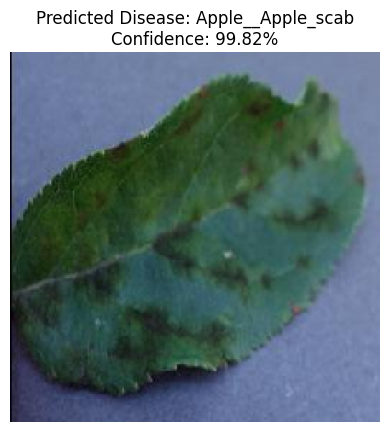

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
import time

# Step 2: Load the trained model
model_path = "/content/drive/MyDrive/apple_leaf_cnn.keras"
model = tf.keras.models.load_model(model_path)
time.sleep(2)  # Wait to ensure the model is fully loaded

# Function to predict disease from uploaded image
def predict_disease(model):
    img_path = "/content/user_image.jpg"  # Uploaded image path
    img = image.load_img(img_path, target_size=(224, 224))  # Resize
    img_array = image.img_to_array(img) / 255.0  # Normalize
    img_array = np.expand_dims(img_array, axis=0)  # Reshape for model

    # Model prediction
    prediction = model.predict(img_array)
    class_index = np.argmax(prediction)
    confidence = float(np.max(prediction))  # Confidence score
    class_labels=['Apple__Apple_scab',
            'Apple__Black_rot',
            'Apple__Cedar_apple_rust',
            'Apple__healthy',
            'Blotch_Apple',
            'Normal_Apple',
            'Rot_Apple',
            'Scab_Apple']

    class_name = class_labels[class_index]  # Get predicted class name

    # Display image and result
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Predicted Disease: {class_name}\nConfidence: {confidence:.2%}")
    plt.show()

# Run prediction on user-uploaded image
predict_disease(cnn_model)


In [ ]:
import numpy as np
from tensorflow.keras.preprocessing import image
from google.colab import files
import shutil

# Function to predict disease
def predict_disease(img_path, model):
    img = image.load_img(img_path, target_size=(224, 224))  # Resize
    img_array = image.img_to_array(img) / 255.0  # Normalize
    img_array = np.expand_dims(img_array, axis=0)  # Reshape for model

    prediction = model.predict(img_array)  # Get predictions
    class_index = np.argmax(prediction)  # Get highest probability class
    class_name = class_labels[class_index]  # Get class name

    print(f"Predicted Disease: {class_name}")

# Upload image
uploaded = files.upload()

# Move uploaded file to a known path
image_path = list(uploaded.keys())[0]
shutil.move(image_path, "/content/user_image.jpg")

print("Image uploaded successfully!")

Saving _0_58.png to _0_58.png
Image uploaded successfully!


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


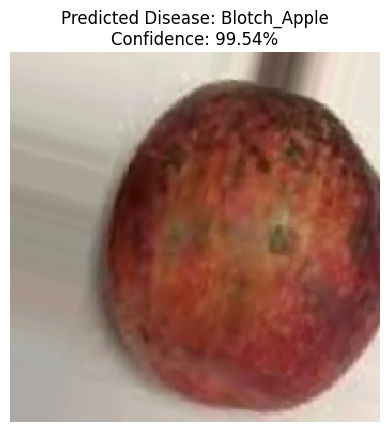

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
import time

# Step 2: Load the trained model
model_path = "/content/drive/MyDrive/apple_leaf_cnn.keras"
model = tf.keras.models.load_model(model_path)
time.sleep(2)  # Wait to ensure the model is fully loaded

# Function to predict disease from uploaded image
def predict_disease(model):
    img_path = "/content/user_image.jpg"  # Uploaded image path
    img = image.load_img(img_path, target_size=(224, 224))  # Resize
    img_array = image.img_to_array(img) / 255.0  # Normalize
    img_array = np.expand_dims(img_array, axis=0)  # Reshape for model

    # Model prediction
    prediction = model.predict(img_array)
    class_index = np.argmax(prediction)
    confidence = float(np.max(prediction))  # Confidence score
    class_labels=['Apple__Apple_scab',
            'Apple__Black_rot',
            'Apple__Cedar_apple_rust',
            'Apple__healthy',
            'Blotch_Apple',
            'Normal_Apple',
            'Rot_Apple',
            'Scab_Apple']

    class_name = class_labels[class_index]  # Get predicted class name

    # Display image and result
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Predicted Disease: {class_name}\nConfidence: {confidence:.2%}")
    plt.show()

# Run prediction on user-uploaded image
predict_disease(cnn_model)


In [ ]:
import numpy as np
from tensorflow.keras.preprocessing import image
from google.colab import files
import shutil

# Function to predict disease
def predict_disease(img_path, model):
    img = image.load_img(img_path, target_size=(224, 224))  # Resize
    img_array = image.img_to_array(img) / 255.0  # Normalize
    img_array = np.expand_dims(img_array, axis=0)  # Reshape for model

    prediction = model.predict(img_array)  # Get predictions
    class_index = np.argmax(prediction)  # Get highest probability class
    class_name = class_labels[class_index]  # Get class name

    print(f"Predicted Disease: {class_name}")

# Upload image
uploaded = files.upload()

# Move uploaded file to a known path
image_path = list(uploaded.keys())[0]
shutil.move(image_path, "/content/user_image.jpg")

print("Image uploaded successfully!")

Saving _0_122.png to _0_122.png
Image uploaded successfully!


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


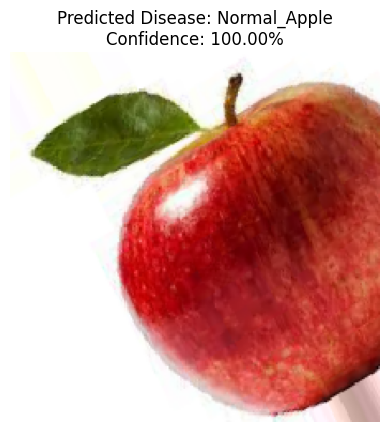

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
import time

# Step 2: Load the trained model
model_path = "/content/drive/MyDrive/apple_leaf_cnn.keras"
model = tf.keras.models.load_model(model_path)
time.sleep(2)  # Wait to ensure the model is fully loaded

# Function to predict disease from uploaded image
def predict_disease(model):
    img_path = "/content/user_image.jpg"  # Uploaded image path
    img = image.load_img(img_path, target_size=(224, 224))  # Resize
    img_array = image.img_to_array(img) / 255.0  # Normalize
    img_array = np.expand_dims(img_array, axis=0)  # Reshape for model

    # Model prediction
    prediction = model.predict(img_array)
    class_index = np.argmax(prediction)
    confidence = float(np.max(prediction))  # Confidence score
    class_labels=['Apple__Apple_scab',
            'Apple__Black_rot',
            'Apple__Cedar_apple_rust',
            'Apple__healthy',
            'Blotch_Apple',
            'Normal_Apple',
            'Rot_Apple',
            'Scab_Apple']

    class_name = class_labels[class_index]  # Get predicted class name

    # Display image and result
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Predicted Disease: {class_name}\nConfidence: {confidence:.2%}")
    plt.show()

# Run prediction on user-uploaded image
predict_disease(cnn_model)
